In [67]:
import sys
import numpy as np
from matplotlib import pyplot as plt

# increase matplotlib resolution
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

# where to save plots
overwrite = True
save_path = "/home/luke/Documents/thesis_plots/"

In [68]:
use_devel = True

# insert the mymujoco path for TrainDQN.py file
if use_devel:
  sys.path.insert(0, "/home/luke/mujoco-devel/rl")
else:
  sys.path.insert(0, "/home/luke/mymujoco/rl")

sys.path.insert(0, "/home/luke/gripper-ros/src/rl/gripper_dqn/scripts/")

# create modelsaver instance
from ModelSaver import ModelSaver
directory = ""#"pb4_tests_apr23" # ""
saver = ModelSaver(f"test_data/{directory}", root="/home/luke/gripper-ros/")

from grasp_test_data import GraspTestData, set_palm_frc_threshold, set_X_frc_threshold, set_Y_frc_threshold
data_explorer = GraspTestData()

# # enter folder and load test data
# test_name = "pb1_E2_S3_YCB_disturb"
# # test_name = "YCB_heuristic"
# saver.enter_folder(test_name)
# try:
#   testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
#   set_palm_frc_threshold(5.0)
#   set_X_frc_threshold(10.0)
#   set_Y_frc_threshold(10.0)
#   data_explorer.add_palm_start_force = False
#   print(data_explorer.get_test_string(data=testdata, detailed=2))

#   # set_palm_frc_threshold(3.0)
#   # print(data_explorer.get_test_string(data=testdata, detailed=True))
# except TypeError as e:
#   print("Loading test data failed, check that the test has actually saved some data")
#   print("Error was:", e)

In [69]:
def get_test_data(tests, Xt=10.0, Yt=10.0, Zt=10.0, add_palm_frc=False, printout=False):

  saver.log_level = 0

  combined_trials = []
  if not isinstance(tests, list):
    tests = [tests]
  for name in tests:
    saver.enter_folder(name)
    testdata = saver.load(id=None, filenamestarts="test_data", suffix_numbering=True)
    for t in testdata.trials:
      combined_trials.append(t)

  testdata.trials = combined_trials
  set_palm_frc_threshold(Zt)
  set_X_frc_threshold(Xt)
  set_Y_frc_threshold(Yt)
  data_explorer.add_palm_start_force = add_palm_frc

  if printout:
    print(data_explorer.get_test_string(data=testdata, detailed=True))

  return data_explorer.get_test_results(data=testdata)

# enter folder and load test data
test_names = ["pb1_E2_S3_real", "pb1_E2_S3_real_disturb"]
test_names = ["pb1_E2_S3_YCB", "palm_E2_75_YCB_e2"]
test_names = ["real_heuristic", "real_heuristic_disturb"]

In [70]:
def combine(item1, item2):
  out = []
  if isinstance(item1, list):
    out = item1
  else: out.append(item1)
  if isinstance(item2, list):
    out += item2
  else: out.append(item2)
  return out

real_tests = [
  ["pb1_E2_S3_real", "pb1_E2_S3_real_disturb_extended"],
  ["real_heuristic", "real_heuristic_disturb_extended"],
  ["shaped_MAT_real", "shaped_MAT_real_disturb"], 
  ["MAT_liftonly_real", "MAT_liftonly_real_disturb"],
]
real_disturb_tests = [
  "pb1_E2_S3_real_disturb_extended",
  "real_heuristic_disturb",
  ["shaped_MAT_real_disturb", "shaped_MAT_real"],
  ["MAT_liftonly_real_disturb", "MAT_liftonly_real"],
]
ycb_tests = [
  ["pb1_E2_S3_YCB", "pb1_E2_S3_YCB_disturb"],
  ["YCB_heuristic", "YCB_heuristic_disturb"],
  ["shaped_MAT_ycb", "shaped_MAT_ycb_disturb"],
  ["MAT_liftonly_ycb", "MAT_liftonly_ycb_disturb"],
]
ycb_disturb_tests = [
  "pb1_E2_S3_YCB_disturb", # palm_E2_75_YCB_e2, this test should be repeated, data is incomplete
  "YCB_heuristic_disturb",
  ["shaped_MAT_ycb_disturb", "shaped_MAT_ycb"],
  ["MAT_liftonly_ycb_disturb", "MAT_liftonly_ycb"],
]
controllers = ["PPO (ours)", "Heuristic", "MAT + ours", "MAT"]

headers = f"{'Controller':<12} | {'Objects':<8} | {'Finger / N':<12} | {'Palm / N':<12} | {'Steps':<8} | {'X tol / N':<9} | {'Y tol / N':<9} | {'Z tol / N':<9} | {'SR %':<8} | {'Stable 5N %':<12} | {'Trials':<6}"
rows = "{:<12} | {:<8} | {:<12.3f} | {:<12.3f} | {:<8.2f} | {:<9.3f} | {:<9.3f} | {:<9.3f} | {:<8.2f} | {:<12.2f} | {:<6}"

# add in 95 confidence interval to success rate and stable 5N rate
add_stat_sig = True
if add_stat_sig:
  headers += f" | {'SR 95CI%':<8} | {'+':<5} | {'-':<5} | {'S5N 95CI%':<9} | {'+':<5} | {'-':<5}"
  rows += " | {:<8.2f} | {:<5.2f} | {:<5.2f} | {:<9.2f} | {:<5.2f} | {:<5.2f}"

print(headers)

real_objects = []
ycb_objects = []

print_alternating = False
print_singles = True
print_both = False

if print_singles:
  for i in range(4 * (1 + (not print_alternating))):
    ind = i
    if print_alternating or i >= 4:
      if not print_alternating: ind -= 4
      ycb_disturb = get_test_data(ycb_disturb_tests[ind], Zt=10.0)
      ycb_main = get_test_data(ycb_tests[ind], Zt=10.0)
      ycb_5N = get_test_data(ycb_tests[ind], Zt=5.0)
      ycb_format = [controllers[ind], "YCB", ycb_main.avg_f_frc, ycb_main.avg_p_frc, ycb_main.avg_steps,
                    ycb_disturb.avg_X_frc_saturated, ycb_disturb.avg_Y_frc_saturated, 
                    ycb_disturb.avg_palm_frc_saturated,
                    ycb_main.avg_SR_per_obj * 100, ycb_5N.rate_palm_frc_tol * 100,
                    ycb_main.num_trials]
      if add_stat_sig:
        ycb_format += [ycb_main.CI_95 * 100, ycb_main.CI_95_max * 100, ycb_main.CI_95_min * 100, 
                      ycb_5N.CI_95_s5N * 100, ycb_5N.CI_95_s5N_max * 100, ycb_5N.CI_95_s5N_min * 100]
      print(rows.format(*ycb_format))
      ycb_objects.append(list(ycb_main.object_sr)[:18])
    if print_alternating or i < 4:
      real_disturb = get_test_data(real_disturb_tests[ind], Zt=10.0)
      real_main = get_test_data(real_tests[ind], Zt=10.0)
      real_5N = get_test_data(real_tests[ind], Zt=5.0)
      real_format = [controllers[ind], "Real", real_main.avg_f_frc, real_main.avg_p_frc, real_main.avg_steps,
                    real_disturb.avg_X_frc_saturated, real_disturb.avg_Y_frc_saturated, 
                    real_disturb.avg_palm_frc_saturated,
                    real_main.avg_SR_per_obj * 100, real_5N.rate_palm_frc_tol * 100,
                    real_main.num_trials]
      if add_stat_sig:
        real_format += [real_main.CI_95 * 100, real_main.CI_95_max * 100, real_main.CI_95_min * 100, 
                        real_5N.CI_95_s5N * 100, real_5N.CI_95_s5N_max * 100, real_5N.CI_95_s5N_min * 100]
      print(rows.format(*real_format))
      real_objects.append(list(real_main.object_sr)[:24])
    
if print_both:
  for ind in range(4):
    both_disturb = get_test_data(combine(ycb_disturb_tests[ind], real_disturb_tests[ind]), Zt=10.0)
    both_main = get_test_data(combine(ycb_tests[ind], real_tests[ind]), Zt=10.0)
    both_5N = get_test_data(combine(ycb_tests[ind], real_tests[ind]), Zt=5.0)
    both_format = [controllers[ind], "YCB+real", both_main.avg_f_frc, both_main.avg_p_frc, both_main.avg_steps,
                   both_disturb.avg_X_frc_saturated, both_disturb.avg_Y_frc_saturated, 
                   both_disturb.avg_palm_frc_saturated,
                   both_main.avg_SR_per_obj * 100, both_5N.rate_palm_frc_tol * 100,
                   both_main.num_trials]
    if add_stat_sig:
      both_format += [both_main.CI_95 * 100, both_main.CI_95_max * 100, both_main.CI_95_min * 100, 
                      both_5N.CI_95_s5N * 100, both_5N.CI_95_s5N_max * 100, both_5N.CI_95_s5N_min * 100]
    print(rows.format(*both_format))

Controller   | Objects  | Finger / N   | Palm / N     | Steps    | X tol / N | Y tol / N | Z tol / N | SR %     | Stable 5N %  | Trials | SR 95CI% | +     | -     | S5N 95CI% | +     | -    
PPO (ours)   | Real     | 0.000        | 0.000        | 40.37    | 4.470     | 5.285     | 7.556     | 95.83    | 79.67        | 240    | 1.45     | 96.92 | 94.38 | 2.65      | 82.08 | 77.02
Heuristic    | Real     | 0.000        | 0.000        | 85.77    | 4.551     | 4.538     | 5.914     | 77.55    | 52.74        | 243    | 2.71     | 80.05 | 74.84 | 3.13      | 55.85 | 49.61
MAT + ours   | Real     | 1.586        | 1.825        | 40.36    | 3.910     | 4.628     | 5.877     | 78.20    | 62.24        | 177    | 3.17     | 81.08 | 75.03 | 3.61      | 65.72 | 58.64
MAT          | Real     | 1.536        | 0.035        | 16.66    | 3.141     | 2.592     | 5.573     | 73.17    | 53.33        | 159    | 3.56     | 76.46 | 69.62 | 3.87      | 57.16 | 49.47
PPO (ours)   | YCB      | 0.000        | 0.00

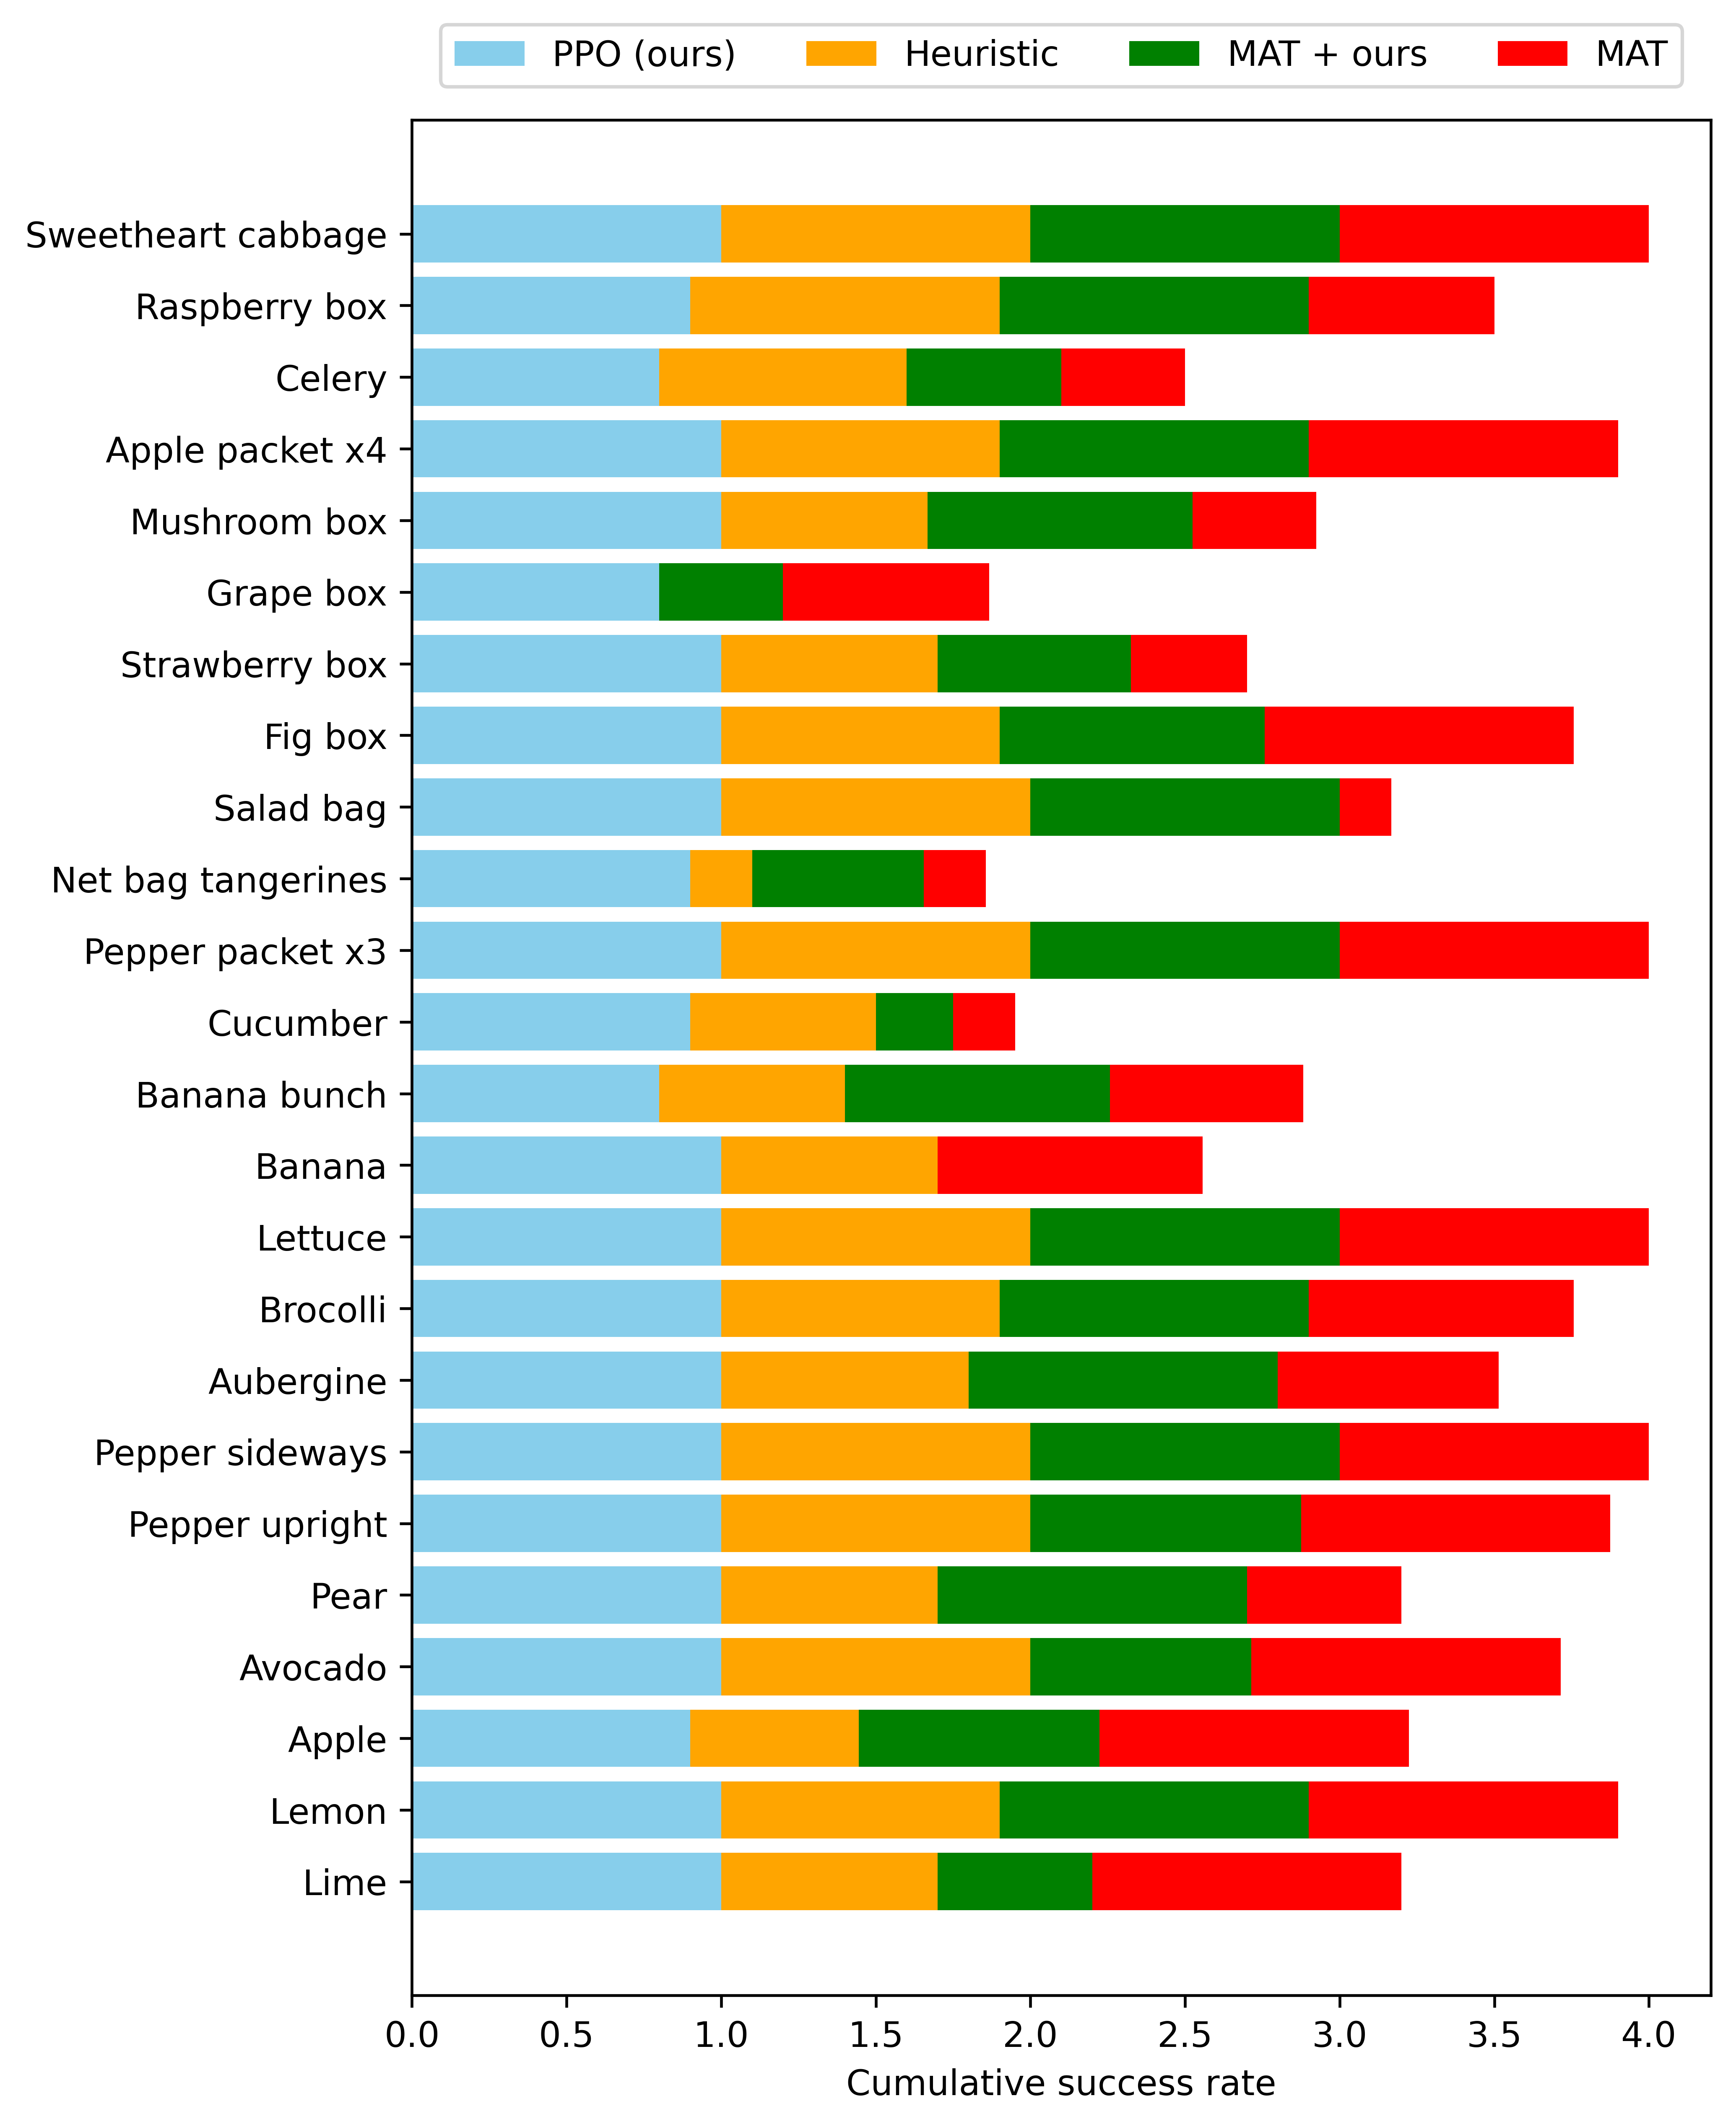

In [71]:
import matplotlib.pyplot as plt
import numpy as np

real_categories = ["Lime", "Lemon", "Apple", "Avocado", "Pear", "Pepper upright", "Pepper sideways", "Aubergine",
              "Brocolli", "Lettuce", "Banana", "Banana bunch", "Cucumber", "Pepper packet x3", "Net bag tangerines",
              "Salad bag", "Fig box", "Strawberry box", "Grape box", "Mushroom box", "Apple packet x4",
              "Celery", "Raspberry box", "Sweetheart cabbage"]

real_data = np.array(real_objects).transpose()

# Colors and labels for the 4 elements in each stack
colors = ['skyblue', 'orange', 'green', 'red']
labels = ['PPO (ours)', 'Heuristic', 'MAT + ours', 'MAT']

# Bar plot configuration
fig, ax = plt.subplots(figsize=(12, 10))

# Stacking the bars
bars = []
for i in range(real_data.shape[1]):
    bars.append(ax.barh(real_categories, real_data[:, i], color=colors[i], left=np.sum(real_data[:, :i], axis=1), label=labels[i]))

# Adding labels and title
ax.set_xlabel('Cumulative success rate')
# ax.set_title('Grasp success rate on real grocery items')
ax.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 1.06))

# Display the plot
fig.set_size_inches(7, 8.5)
fig.tight_layout()

if False and overwrite: fig.savefig(save_path + "real_object_success_rates.png")

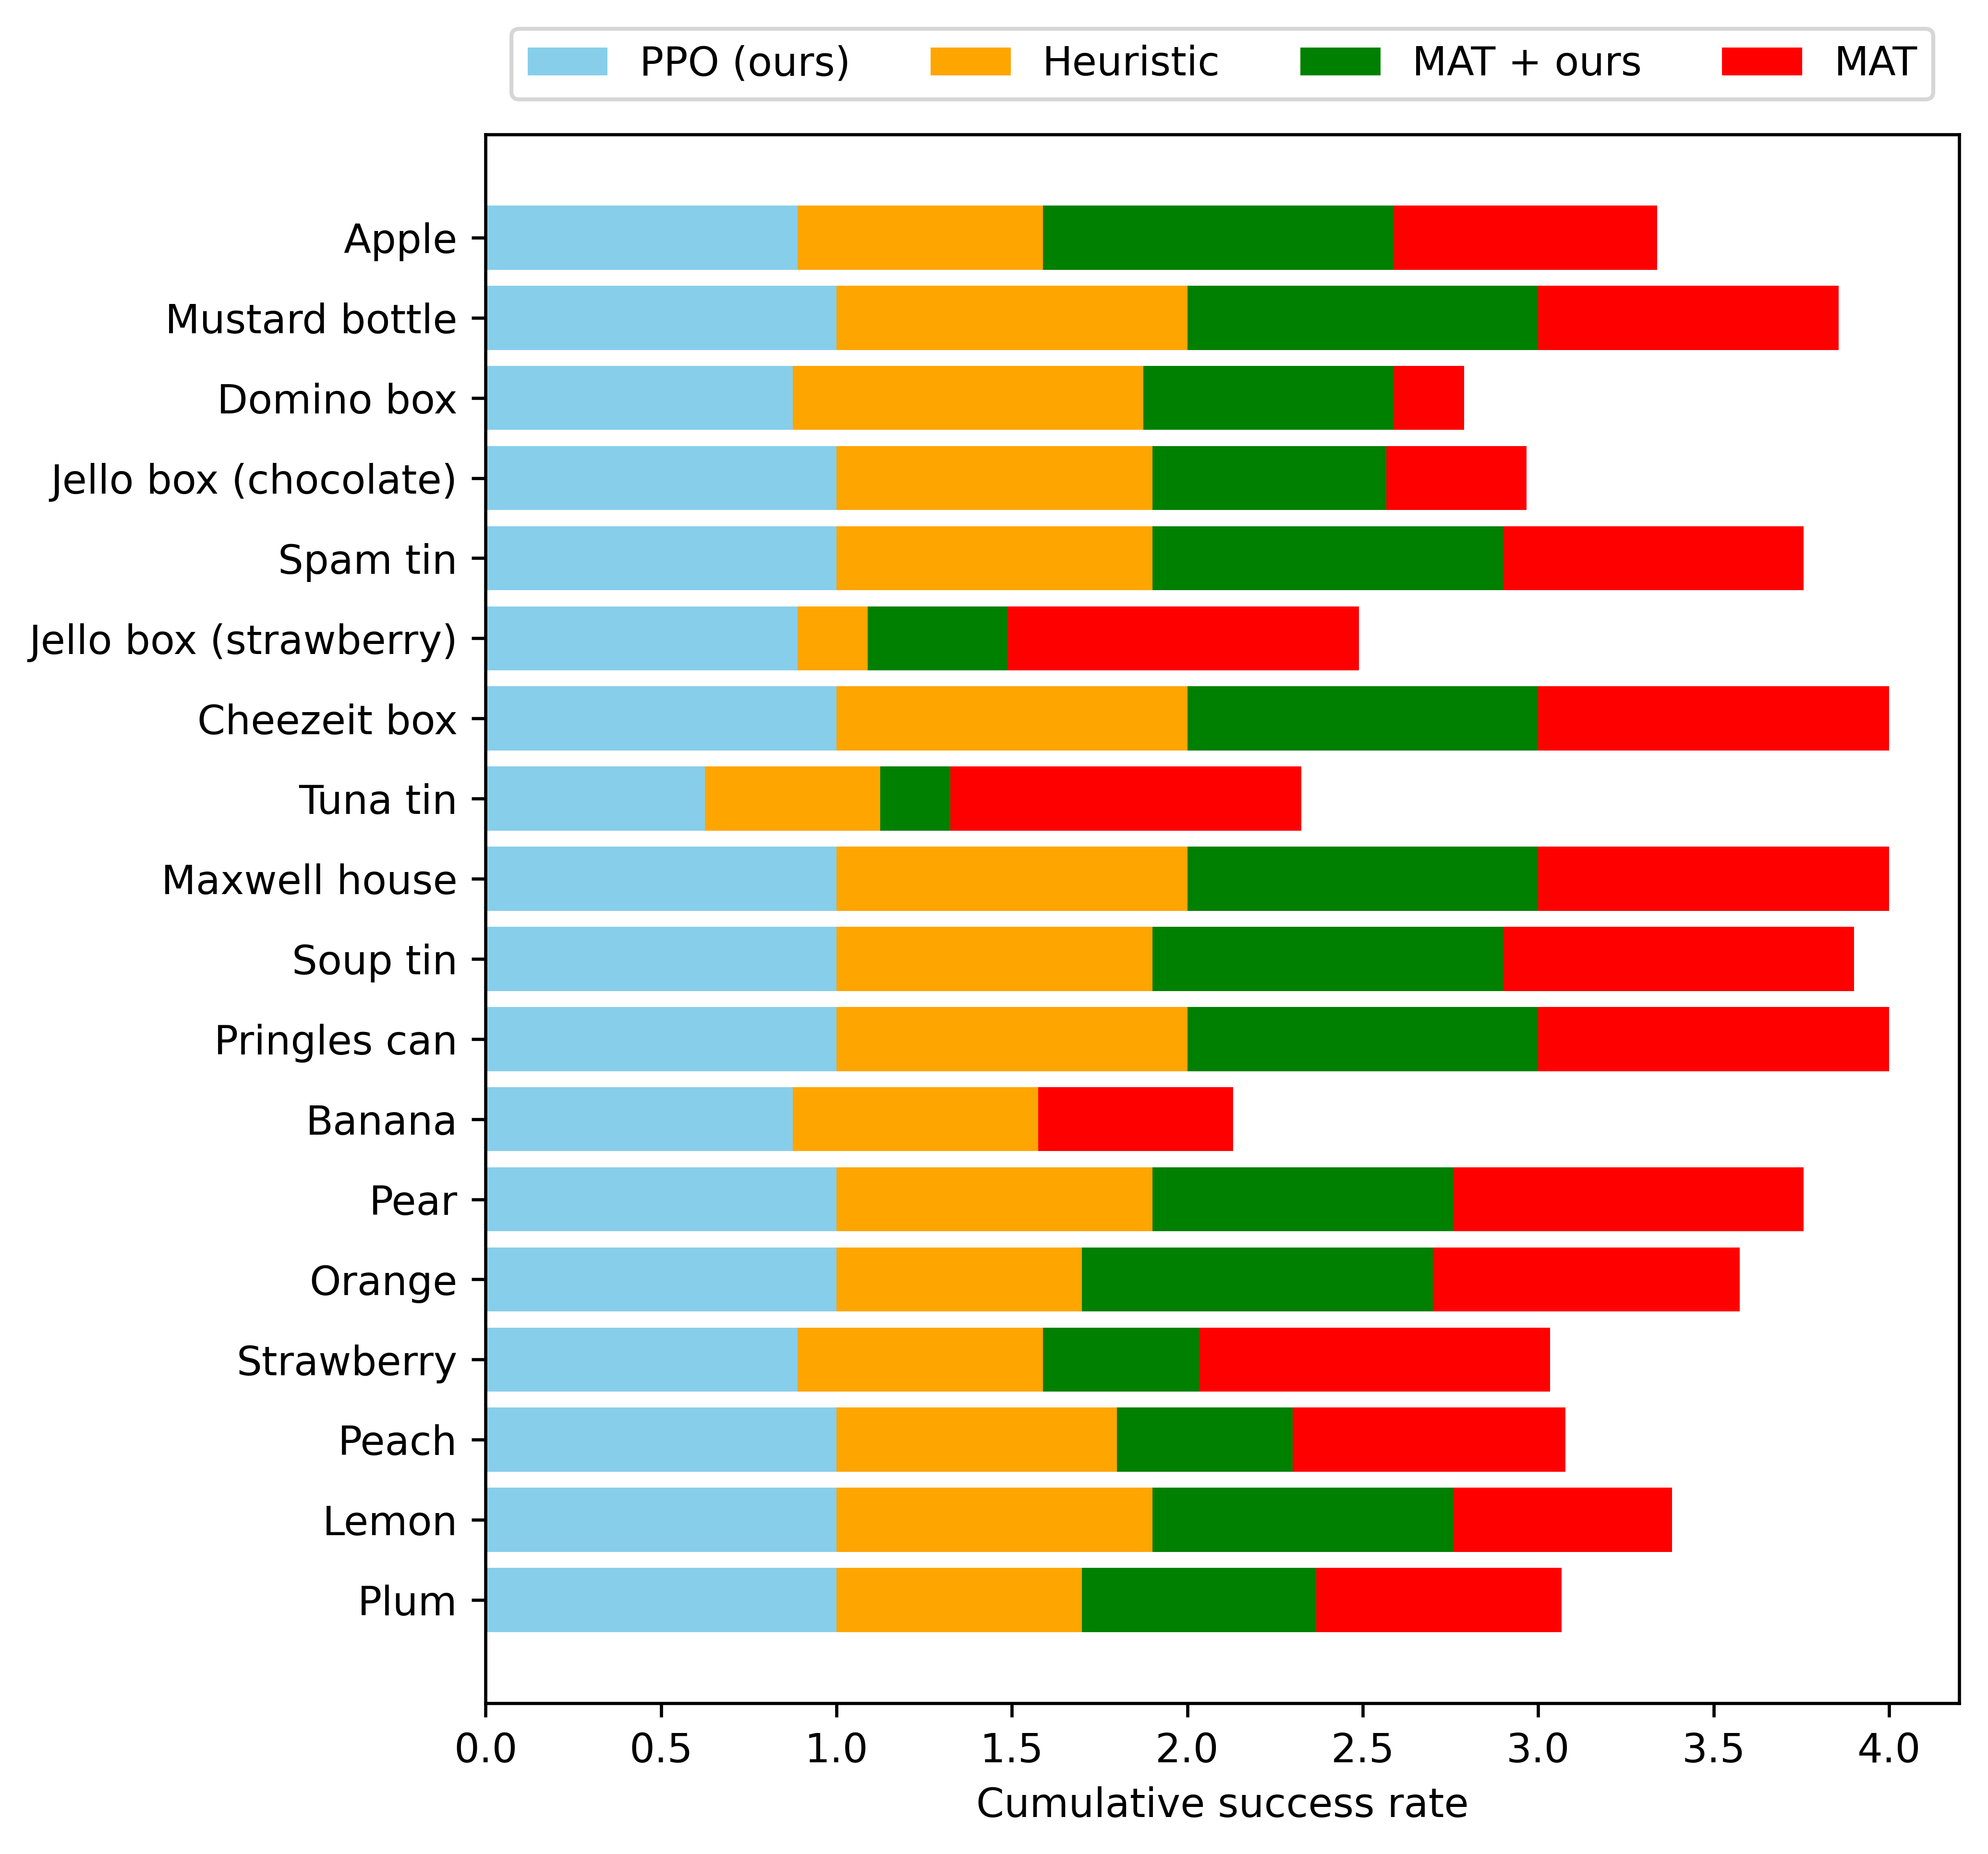

In [72]:
ycb_categories = ["Plum", "Lemon", "Peach", "Strawberry", "Orange", "Pear", "Banana", "Pringles can", "Soup tin",
                  "Maxwell house", "Tuna tin", "Cheezeit box", "Jello box (strawberry)", "Spam tin", "Jello box (chocolate)",
                  "Domino box", "Mustard bottle", "Apple"]

ycb_data = np.array(ycb_objects).transpose()

# Colors and labels for the 4 elements in each stack
colors = ['skyblue', 'orange', 'green', 'red']
labels = ['PPO (ours)', 'Heuristic', 'MAT + ours', 'MAT']

# Bar plot configuration
fig, ax = plt.subplots(figsize=(12, 10))

# Stacking the bars
bars = []
for i in range(ycb_data.shape[1]):
    bars.append(ax.barh(ycb_categories, ycb_data[:, i], color=colors[i], left=np.sum(ycb_data[:, :i], axis=1), label=labels[i]))

# Adding labels and title
ax.set_xlabel('Cumulative success rate')
# ax.set_title('Grasp success rate on YCB grocery items')
ax.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 1.08))

# Display the plot
fig.set_size_inches(7, 6.5)
fig.tight_layout()

if False and overwrite: fig.savefig(save_path + "ycb_object_success_rates.png")

In [75]:
header = f"{'Type':<8} | {'Name':<24} | {'PPO':<8} | {'Heur.':<8} | {'MAT+ours':<8} | {'MAT':<8} | {'All':<8}"
rows = "{:<8} | {:<24} | {:<8.2f} | {:<8.2f} | {:<8.2f} | {:<8.2f} | {:<8.2f}"

print(header)

for i in range(len(real_categories)):
  print(rows.format("Real", real_categories[i], real_data[i, 0], real_data[i, 1], real_data[i, 2], real_data[i, 3], np.average(real_data[i, :],)))

for i in range(len(ycb_categories)):
  print(rows.format("YCB", ycb_categories[i], ycb_data[i, 0], ycb_data[i, 1], ycb_data[i, 2], ycb_data[i, 3], np.average(ycb_data[i, :],)))

Type     | Name                     | PPO      | Heur.    | MAT+ours | MAT      | All     
Real     | Lime                     | 1.00     | 0.70     | 0.50     | 1.00     | 0.80    
Real     | Lemon                    | 1.00     | 0.90     | 1.00     | 1.00     | 0.97    
Real     | Apple                    | 0.90     | 0.55     | 0.78     | 1.00     | 0.81    
Real     | Avocado                  | 1.00     | 1.00     | 0.71     | 1.00     | 0.93    
Real     | Pear                     | 1.00     | 0.70     | 1.00     | 0.50     | 0.80    
Real     | Pepper upright           | 1.00     | 1.00     | 0.88     | 1.00     | 0.97    
Real     | Pepper sideways          | 1.00     | 1.00     | 1.00     | 1.00     | 1.00    
Real     | Aubergine                | 1.00     | 0.80     | 1.00     | 0.71     | 0.88    
Real     | Brocolli                 | 1.00     | 0.90     | 1.00     | 0.86     | 0.94    
Real     | Lettuce                  | 1.00     | 1.00     | 1.00     | 1.00     | 1.00    